In [67]:
import geopandas as gpd
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import osmnx as ox
import pandas as pd
import pickle
from pathlib import Path
import os
import tqdm


EPSILON = 1e-3

In [55]:
class City:

    def __init__(self, g, rho=2):

        self.rho = rho
        self.cwd = Path.cwd()

        self.g = g
        for _, data in self.g.nodes(data=True):
            data['amt'] = False
            data['inh'] = set()
            data['dow_thr'] = 0
            data['upk'] = None
            data['cmt'] = None
            data['pop_hist'] = []
            data['cmt_hist'] = []

        self.diam = nx.diameter(self.g, weight='length')
        self.dist = dict(nx.all_pairs_dijkstra_path_length(self.g, weight='length'))
        self.dist = pd.DataFrame.from_dict(self.dist).sort_index() / self.diam
        self.dist = self.dist.to_numpy()

        self.amts = None
        self.amts_dist = None

        self.agts = None
        self.agt_dows = None

    def set_amts(self, amts):
        self.amts = amts
        for u in self.amts:
            data = self.g.nodes[u]
            data['amt'] = True
            data['inh'] = None
            data['dow_thr'] = None
            data['upk'] = None
            data['cmt'] = None
            data['pop_hist'] = None
            data['cmt_hist'] = None
        self.amts_dist = np.array([min(self.dist[u][v] for v in self.amts) for u in self.g.nodes()])

    def set_agts(self, agts):
        self.agts = agts
        self.agt_dows = np.array([a.dow for a in self.agts])

    def update(self):
        for u, data in self.g.nodes(data=True):
            if data['amt']:
                continue
            pop = len(data['inh'])
            cmt = np.average(self.agt_dows, weights=[(1 - self.dist[u][a.u]) ** 2 for a in self.agts])
            if pop > 0:
                if pop < self.rho:
                    data['dow_thr'] = 0
                else:
                    data['dow_thr'] = sorted([a.dow for a in self.g.nodes[u]['inh']])[-self.rho]
                data['upk'] = True
            else:
                data['dow_thr'] = 0
                data['upk'] = False
            data['cmt'] = cmt

            data['pop_hist'].append(pop)
            data['cmt_hist'].append(cmt)

    def plot(self, cmap='YlOrRd', figkey=None):

        for u, data in self.g.nodes(data=True):
            if not data['amt']:
                data['dow'] = np.average(self.agt_dows, weights=[a.avg_probabilities[u] for a in self.agts])
                data['dow'] = (data['dow'] - min(self.agt_dows)) / (max(self.agt_dows) - min(self.agt_dows))
                data['pop'] = np.sum([a.avg_probabilities[u] for a in self.agts])
            else:
                data['dow'] = np.nan
                data['pop'] = np.nan

        no_agts = len(self.agts)
        node_size = [no_agts / 10 * data['pop'] if not data['amt'] else no_agts / 2.5 for _, data in self.g.nodes(data=True)]
        node_color = ox.plot.get_node_colors_by_attr(self.g, 'dow', start=0, stop=1, na_color='b', cmap=cmap)
        fig, ax = plt.subplots(figsize=(9, 6))
        cb = fig.colorbar(
            plt.cm.ScalarMappable(cmap=plt.colormaps[cmap]), ax=ax, location='bottom', shrink=0.5, pad=0.05
        )
        cb.set_label('Expected Endowment', fontsize=14)
        ox.plot_graph(self.g, ax=ax, bgcolor='w', node_color=node_color, node_size=node_size)
        plt.show()
        if figkey is not None:
            plt.savefig(Path(self.cwd / 'figures/{0}.pdf'.format(figkey)), bbox_inches='tight', format='pdf')


class Agent:

    def __init__(self, i, dow, city, alpha=0.5):

        self.i = i
        self.dow = dow
        self.city = city
        self.alpha = alpha

        self.weights = None
        self.probabilities = None
        self.tot_probabilities = None
        self.avg_probabilities = None
        self.u = None

        self.reset()

    def __hash__(self):
        return hash(self.i)

    def __eq__(self, other):
        return self.i == other.i

    def reset(self):
        self.weights = np.array([1.0 if not data['amt'] else 0 for _, data in self.city.g.nodes(data=True)])
        self.probabilities = np.array(self.weights / self.weights.sum())
        self.tot_probabilities = self.probabilities.copy()
        self.u = np.random.choice(self.city.g.nodes(), p=self.probabilities)
        self.city.g.nodes[self.u]['inh'].add(self)

    def act(self):
        self.city.g.nodes[self.u]['inh'].remove(self)
        self.u = np.random.choice(self.city.g.nodes(), p=self.probabilities)
        self.city.g.nodes[self.u]['inh'].add(self)

    def learn(self):
        for u in self.city.g.nodes():
            if not self.city.g.nodes[u]['amt']:
                self.weights[u] *= (1 - EPSILON * self.cost(u))
        self.probabilities = np.array(self.weights / self.weights.sum())
        self.tot_probabilities += self.probabilities

    def cost(self, u):
        aff = int(self.dow >= self.city.g.nodes[u]['dow_thr'])
        loc = np.exp(- (1 - self.alpha) * self.city.amts_dist[u])
        upk = int(self.city.g.nodes[u]['upk'])
        cmt = np.exp(- self.alpha * np.abs(self.dow - self.city.g.nodes[u]['cmt']))
        c = 1 - aff * loc * upk * cmt
        return c

In [70]:
import requests
import zipfile
from pathlib import Path
from tqdm import tqdm

def download_and_extract_file(url, filename):
    # Use a 'data' subfolder in the current working directory
    cwd = Path.cwd()
    data_dir = cwd / "data"
    data_dir.mkdir(exist_ok=True)  # Create the 'data' directory if it doesn't exist
    file_path = data_dir / filename

    # Create extraction subfolder name (remove .zip extension)
    extract_folder_name = filename.rsplit('.', 1)[0]
    extract_path = data_dir / extract_folder_name
    
    # Check if file already exists
    if file_path.exists():
        print(f"{filename} already exists in {data_dir}. Skipping download.")
    else:
        # Make the request
        print(f"Downloading {filename} to {data_dir}...")
        response = requests.get(url, stream=True)
        
        # Check if the request was successful
        if response.status_code == 200:
            # Get the total file size
            total_size = int(response.headers.get('content-length', 0))

            # Open the file and use tqdm for the progress bar
            with file_path.open('wb') as file, tqdm(
                desc=filename,
                total=total_size,
                unit='iB',
                unit_scale=True,
                unit_divisor=1024,
            ) as progress_bar:
                for data in response.iter_content(chunk_size=1024):
                    size = file.write(data)
                    progress_bar.update(size)
            print(f"Successfully downloaded {filename}")
        else:
            print(f"Failed to download {filename}. Status code: {response.status_code}")
            return

    # Extract the ZIP file
    print(f"Extracting {filename} to {extract_path}...")
    extract_path.mkdir(exist_ok=True)  # Create the extraction folder if it doesn't exist
    with zipfile.ZipFile(file_path, 'r') as zip_ref:
        # Get the total number of files in the ZIP
        total_files = len(zip_ref.infolist())
        
        # Use tqdm for the extraction progress bar
        for file in tqdm(zip_ref.infolist(), desc="Extracting", total=total_files):
            zip_ref.extract(file, extract_path)
    
    print(f"Successfully extracted {filename} to {extract_path}")

# URL of the file to download
url = "https://www2.census.gov/geo/tiger/TIGER2022/ZCTA520/tl_2022_us_zcta520.zip"

# Filename to save as
filename = "tl_2022_us_zcta520.zip"

# Call the function to download and extract the file
download_and_extract_file(url, filename)

tl_2022_us_zcta520.zip already exists in c:\Users\pkastner\Documents\GitHub\modeling_processes_of_neighborhood_change\data. Skipping download.
Extracting tl_2022_us_zcta520.zip to c:\Users\pkastner\Documents\GitHub\modeling_processes_of_neighborhood_change\data\tl_2022_us_zcta520...


Extracting: 100%|██████████| 7/7 [00:02<00:00,  2.54it/s]

Successfully extracted tl_2022_us_zcta520.zip to c:\Users\pkastner\Documents\GitHub\modeling_processes_of_neighborhood_change\data\tl_2022_us_zcta520


c:\Users\pkastner\Documents\GitHub\modeling_processes_of_neighborhood_change
t: 0
t: 1
t: 2
t: 3
t: 4
t: 5
t: 6
t: 7
t: 8
t: 9
t: 10
t: 11
t: 12
t: 13
t: 14
t: 0
t: 1
t: 2
t: 3
t: 4
t: 5
t: 6
t: 7
t: 8
t: 9
t: 10
t: 11
t: 12
t: 13
t: 14
t: 0
t: 1
t: 2
t: 3
t: 4
t: 5
t: 6
t: 7
t: 8
t: 9
t: 10
t: 11
t: 12
t: 13
t: 14
t: 0
t: 1
t: 2
t: 3
t: 4
t: 5
t: 6
t: 7
t: 8
t: 9
t: 10
t: 11
t: 12
t: 13
t: 14
t: 0
t: 1
t: 2
t: 3
t: 4
t: 5
t: 6
t: 7
t: 8
t: 9
t: 10
t: 11
t: 12
t: 13
t: 14
t: 0
t: 1
t: 2
t: 3
t: 4
t: 5
t: 6
t: 7
t: 8
t: 9
t: 10
t: 11
t: 12
t: 13
t: 14
t: 0
t: 1
t: 2
t: 3
t: 4
t: 5
t: 6
t: 7
t: 8
t: 9
t: 10
t: 11
t: 12
t: 13
t: 14
t: 0
t: 1
t: 2
t: 3
t: 4
t: 5
t: 6
t: 7
t: 8
t: 9
t: 10
t: 11
t: 12
t: 13
t: 14


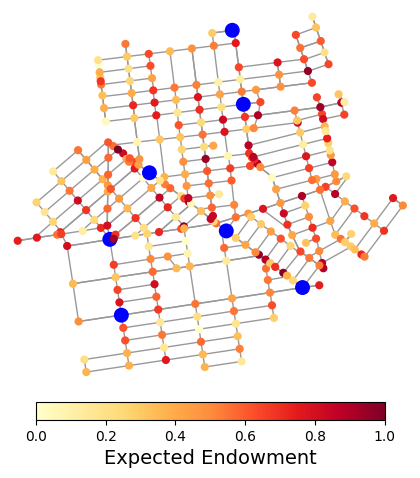

<Figure size 640x480 with 0 Axes>

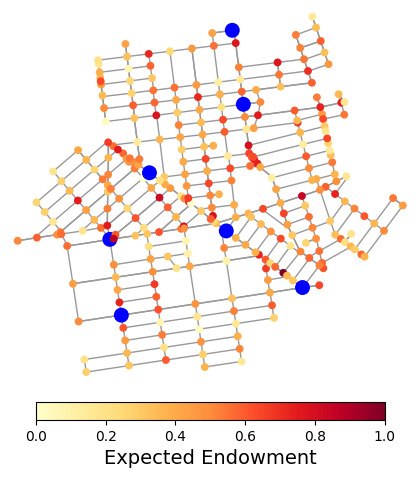

<Figure size 640x480 with 0 Axes>

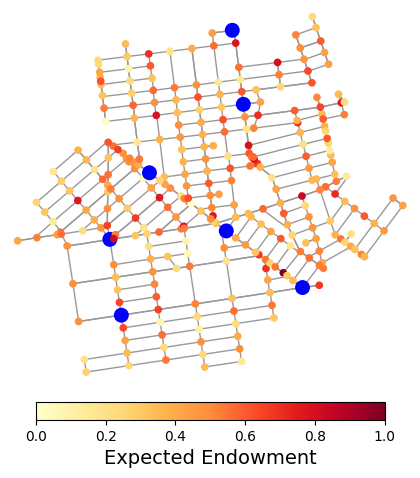

<Figure size 640x480 with 0 Axes>

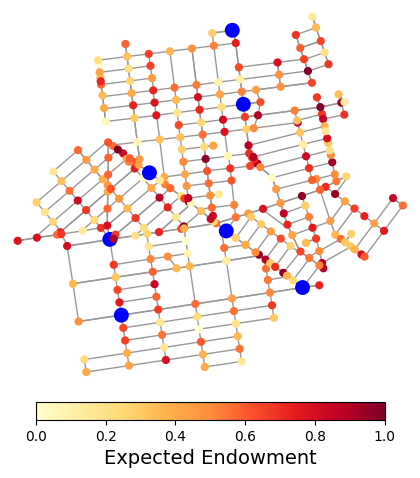

<Figure size 640x480 with 0 Axes>

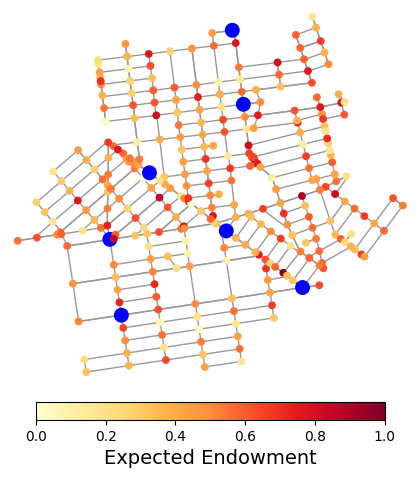

<Figure size 640x480 with 0 Axes>

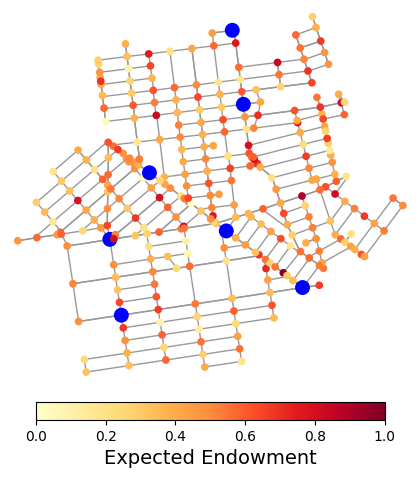

<Figure size 640x480 with 0 Axes>

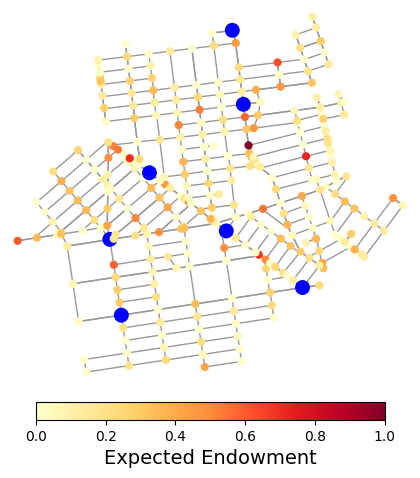

<Figure size 640x480 with 0 Axes>

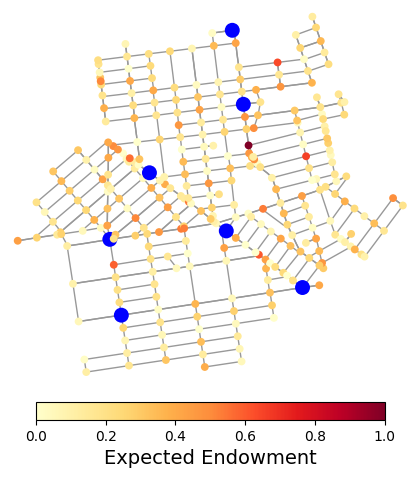

<Figure size 640x480 with 0 Axes>

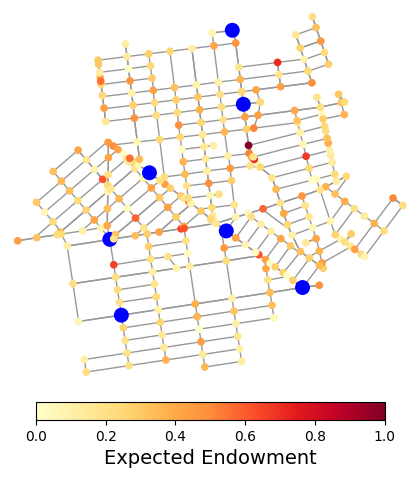

<Figure size 640x480 with 0 Axes>

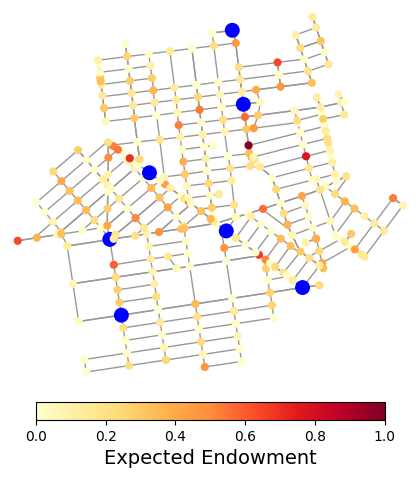

<Figure size 640x480 with 0 Axes>

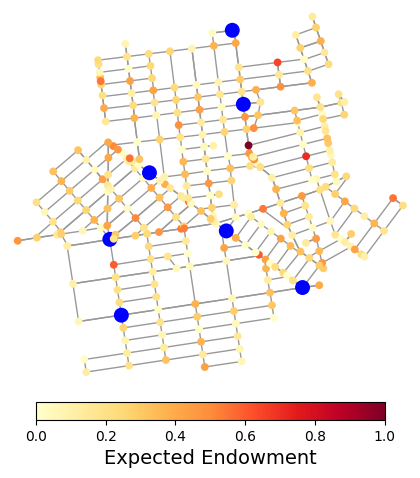

<Figure size 640x480 with 0 Axes>

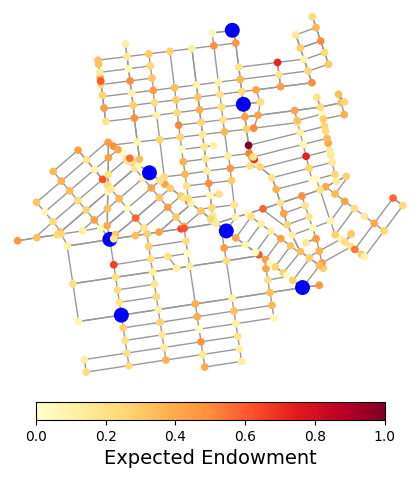

<Figure size 640x480 with 0 Axes>

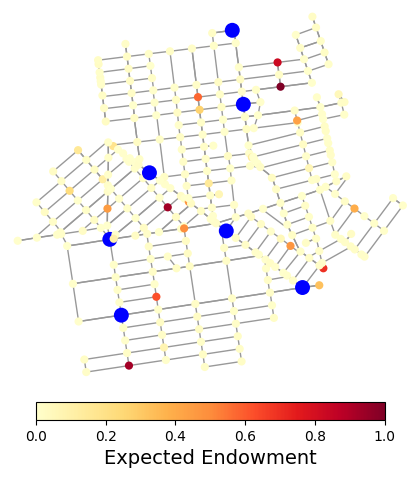

<Figure size 640x480 with 0 Axes>

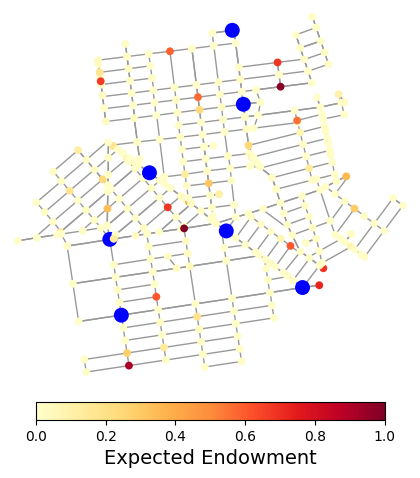

<Figure size 640x480 with 0 Axes>

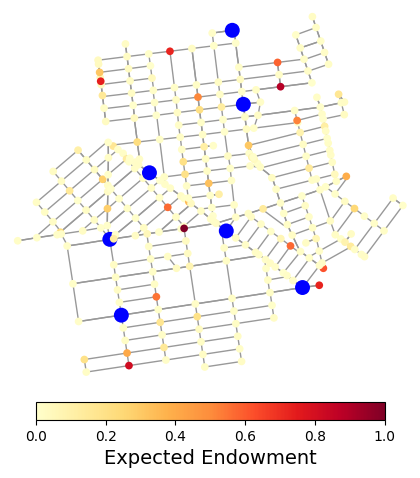

<Figure size 640x480 with 0 Axes>

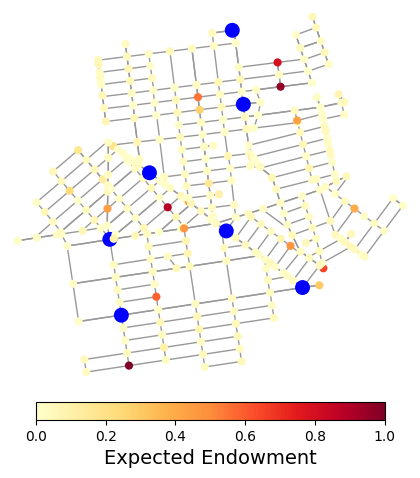

<Figure size 640x480 with 0 Axes>

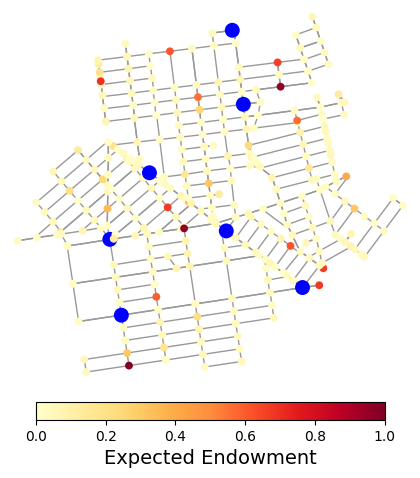

<Figure size 640x480 with 0 Axes>

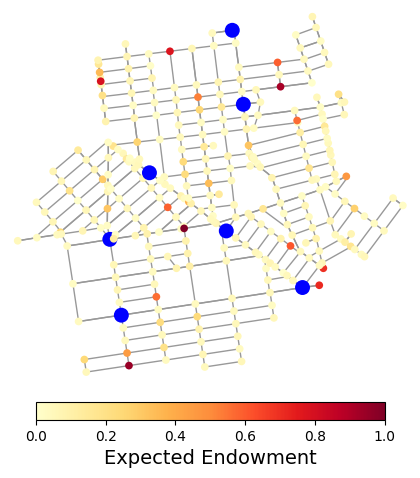

<Figure size 640x480 with 0 Axes>

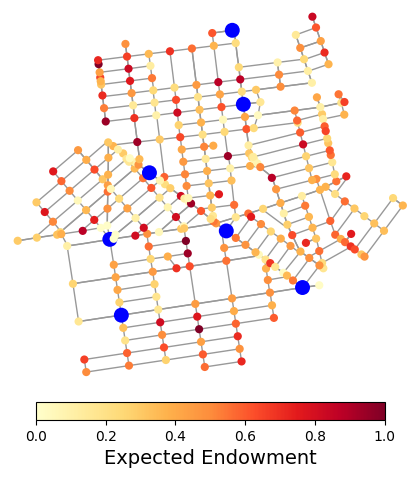

<Figure size 640x480 with 0 Axes>

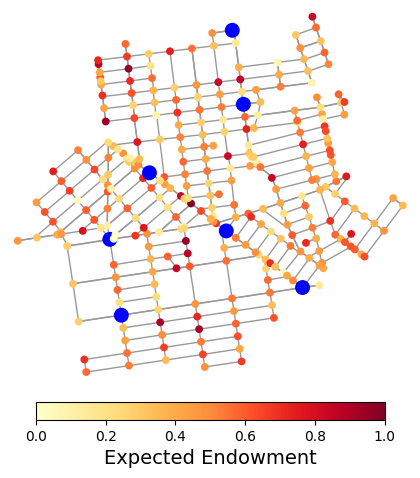

<Figure size 640x480 with 0 Axes>

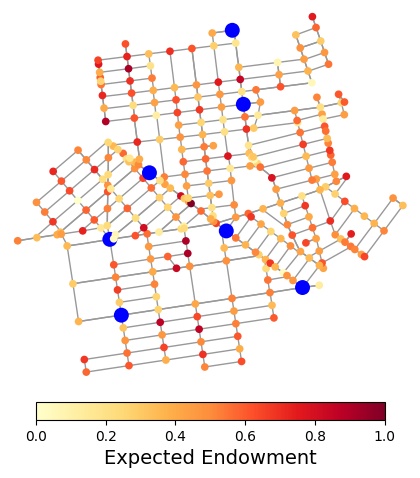

<Figure size 640x480 with 0 Axes>

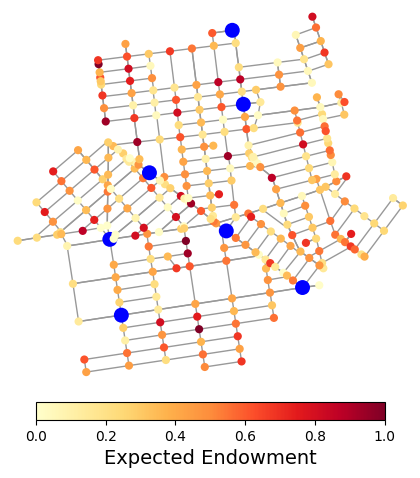

<Figure size 640x480 with 0 Axes>

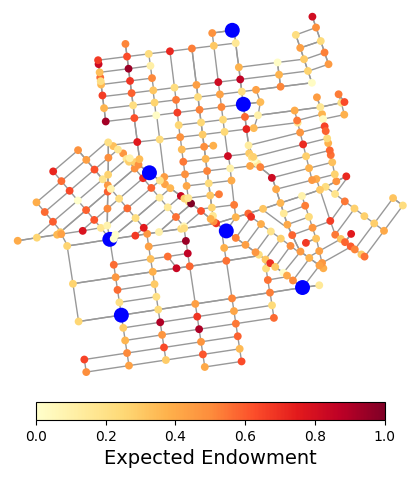

<Figure size 640x480 with 0 Axes>

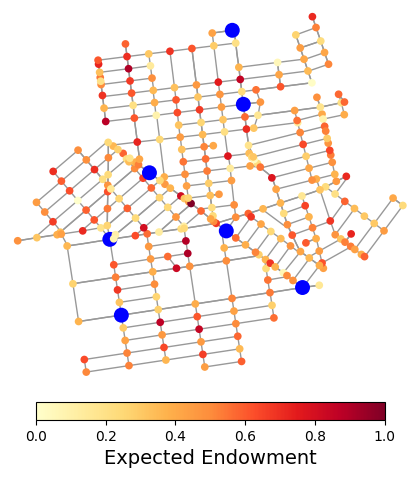

<Figure size 640x480 with 0 Axes>

In [56]:
cwd = Path.cwd()
print(cwd)
figures_folder = Path(cwd / "figures")
if not os.path.isdir(figures_folder):
    os.makedirs(figures_folder)




stations = [
    (40.69978508399301, -73.95003262834037, 'Flushing Av'),
    (40.70391698978126, -73.94732896174611, 'Lorimer St'),
    (40.695327543912875, -73.94917432148505, 'Myrtle-Willoughby Avs'),
    (40.71178967550891, -73.94041959156081, 'Grand St'),
    (40.70765825814149, -73.93994752279038, 'Montrose Av'),
    (40.700273117710545, -73.94114915238782, 'Flushing Av'),
    (40.69711710313728, -73.93557015782827, 'Myrtle Av')
]


load_g = False
if not load_g:
    gdf = gpd.read_file(cwd / Path('data/tl_2022_us_zcta520/tl_2022_us_zcta520.shp'))
    gdf = gdf[gdf['ZCTA5CE20'] == '11206']
    shape = gdf.iloc[0].geometry
    g = ox.graph_from_polygon(shape, network_type='drive', simplify=True)
    g = g.subgraph(max(nx.strongly_connected_components(g), key=len)).copy()
    g = nx.convert_node_labels_to_integers(g)
    with open(Path(cwd / 'data/tl_2022_us_zcta520/williamsburg.pkl'), 'wb') as file:
        pickle.dump(g, file)
else:
    with open(Path(cwd / 'data/tl_2022_us_zcta520/williamsburg.pkl'), 'rb') as file:
        g = pickle.load(file)
amts = [ox.nearest_nodes(g, lon, lat) for lat, lon, _ in stations]





rho_l = [1, 2, 4, 8]
alpha_l = [0.25, 0.75]
t_max_l = [5,10,15]  # [5000, 10000, 15000, 20000]
tau = 0.5
run_experiments = True
plot_cities = True
cty_key = 'williamsburg'

n = g.number_of_nodes() - len(amts)
if run_experiments:
    for rho in rho_l:
        for alpha in alpha_l:

            np.random.seed(0)

            city = City(g, rho=rho)
            city.set_amts(amts)

            agt_dows = np.diff([1 - (1 - x) ** tau for x in np.linspace(0, 1, n + 1)])
            agts = [Agent(i, dow, city, alpha=alpha) for i, dow in enumerate(agt_dows)]

            city.set_agts(agts)
            city.update()

            for t in range(max(t_max_l)):
                print('t: {0}'.format(t))
                for a in agts:
                    a.act()
                city.update()
                for a in agts:
                    a.learn()

                if t + 1 in t_max_l:

                    for a in city.agts:
                        a.avg_probabilities = a.tot_probabilities / (t + 1)

                    with open(Path(cwd / 'data/{0}_{1}_{2}_{3}.pkl'.format(cty_key, rho, alpha, t + 1)), 'wb') as file:
                        pickle.dump(city, file)

if plot_cities:
    for rho in rho_l:
        for alpha in alpha_l:
            for t_max in t_max_l:
                with open(Path(cwd / 'data/{0}_{1}_{2}_{3}.pkl'.format(cty_key, rho, alpha, t_max)), 'rb') as file:
                    city = pickle.load(file)
                cmap = 'YlOrRd'
                figkey = '{0}_{1}_{2}_{3}'.format(cty_key, rho, alpha, t_max)
                city.plot(cmap=cmap, figkey=figkey)
